# Data modeling

by Bart De Vylder and Pieter Buteneers (@pieterbuteneers) from CoScale


## 1. Imports

Let's first start with importing all the necessary packages. Some imports will be repeated in the exercises but if you want to skip some parts you can just execute the imports below and start with any exercise.

As you can see we also import packages from `__future__`. This is to improve the compatibility with Python 3, but will not guarantee it.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 14.0)
%matplotlib inline

import pickle

import sklearn
import sklearn.linear_model
import sklearn.preprocessing
import sklearn.gaussian_process
import sklearn.ensemble

# to make the code is compatible with python 3
from __future__ import print_function   # turns print into a function
from __future__ import division         # makes sure 3/2 = 1.5 and not 1 (use 3//2 = 1 instead)

## 2. Linear Regression

Linear Regression assumes a linear realationship between 2 variables. 

As an example we'll consider the historical page views of a web server and compare it to its CPU usage. We'll try to predict the CPU usage of the server based on the page views of the different pages. 

### 2.1 Data import and inspection

Let's import the data and take a look at it.

In [2]:
import pickle
import sys
if sys.version_info[0] < 3:
    cpu_usage, page_views, page_names, _ = pickle.load(open('data/cpu_page_views.pickle'))
else:
    cpu_usage, page_views, page_names, _ = pickle.load(open('data/cpu_page_views.pickle', 'rb'), encoding='latin1')

Lets take a look at the data. For CPU we get:

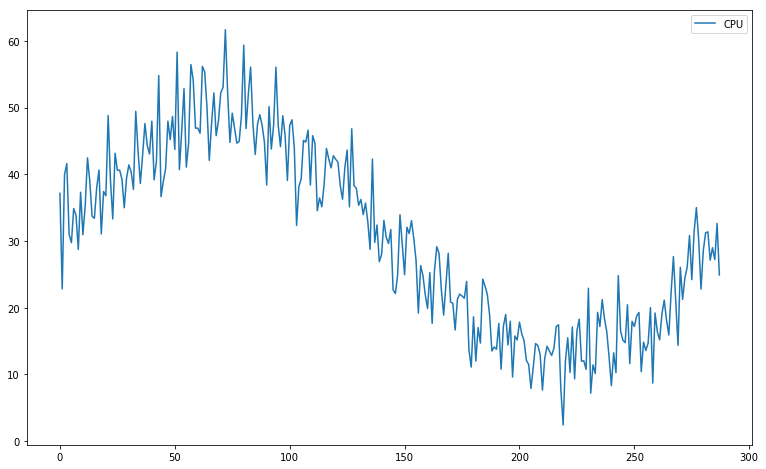

In [3]:
plt.figure(figsize=(13,8))
plt.plot(cpu_usage, label='CPU')
plt.legend(loc='upper right')
plt.show()

And now at the individual pageviews. First we check the pageview format: its a table that consists of 288 rows and 6 columns, to get out individual timeseries we need to transpose it.

In [4]:
page_views.shape

(288, 6)

In [5]:
np.transpose(page_views).shape

(6, 288)

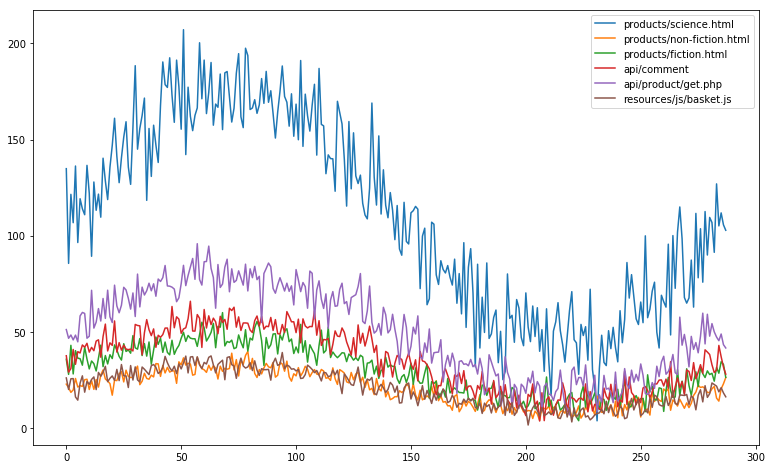

In [6]:
plt.figure(figsize=(13,8))
for page_name, timeseries in zip(page_names, np.transpose(page_views)):
    plt.plot(timeseries, label=page_name)
plt.legend(loc='upper right')
plt.show()

### 2.2 Simple linear regression

First, we're going to work with the total page views on the server, and compare it to the CPU usage. The numpy function [np.sum](http://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html)  can be used to calculate the total request rate when selecting the right direction (axis=1) for the summation.

In [7]:
### BEGIN SOLUTION 
total_page_views = np.sum(page_views, axis=1) 
### END SOLUTION
# total_request_rate =

assert total_page_views.shape == (288,)

Let's plot the total request rate to check:

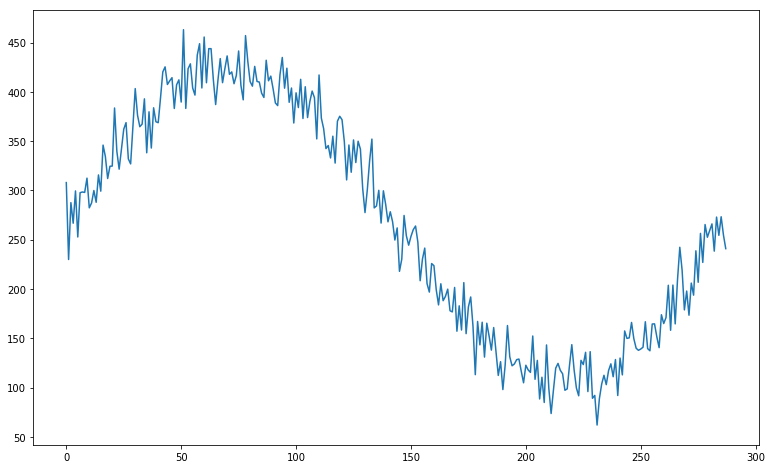

In [8]:
plt.figure(figsize=(13,8))
plt.plot(total_page_views)

We can make use of a [PyPlot's scatter plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) to understand the relation between the total page views and the CPU usage:

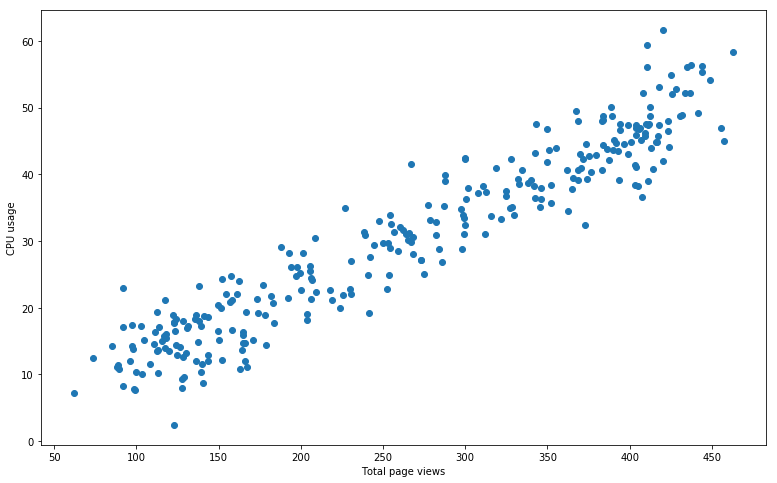

In [9]:
plt.figure(figsize=(13,8))
plt.xlabel("Total page views")
plt.ylabel("CPU usage")
### BEGIN SOLUTION
plt.scatter(total_page_views, cpu_usage)
### END SOLUTION
# plt.scatter( ? , ? )

There clearly is a strong correlation between the page views and the CPU usage. Because of this correlation we can build a model to predict the CPU usage from the total page views. If we use a linear model we get a formula like the following:

$$ \text{cpu_usage} = c_0 + c_1 \text{total_page_views} $$

Since we don't know the exact values for $c_0$ and $c_1$ we will have to compute them. For that we'll make use of the [scikit-learn](http://scikit-learn.org/stable/) machine learning library for Python and use [least-squares linear regression](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

In [10]:
import sklearn.linear_model
simple_lin_model = sklearn.linear_model.LinearRegression()

Now we need to feed the data to the model to fit it. The [model.fit(X,y) method](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) in general takes a matrix X and vector y as arguments:
```
      X = [[x_11, x_12, x_13, ...],                  y = [y_1,
           [x_21, x_22, x_23, ...],                       y_2,  
           [x_31, x_32, x_33, ...],                       y_3,
           ...]                                           ...]

```

and tries to find coefficients that allow to predict the `y_i`'s from the `x_ij`'s. In our case the matrix X will consist of only 1 column containing the total page views. Our `total_page_views` variable however, is still only a one-dimensional vector, so we need to [`np.reshape()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) it into a two-dimensional array. Since there is only 1 feature the second dimension should be 1.

Then we fit our model using the the total page views and cpu. The coefficients found are automatically stored in the ```simple_lin_model``` object.

In [11]:
### BEGIN SOLUTION
total_page_views_M = np.reshape(total_page_views, (-1,1))
### END SOLUTION
# total_request_rate_M = 

# Test to see it's a two dimensional array
assert len(total_page_views_M.shape) == 2
# Test to see it's got only 1 column
assert total_page_views_M.shape[1] == 1

Then we fit our model using the the total request rate and cpu. The coefficients found are automatically stored in the ```simple_lin_model``` object.

In [12]:
### BEGIN SOLUTION
simple_lin_model.fit(total_page_views_M, cpu_usage)
### END SOLUTION
# simple_lin_model.fit( ? , ? ) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We can now inspect the coefficient $c_1$ and constant term (intercept) $c_0$ of the model:

In [13]:
print("Coefficient = %s, constant term = %f" % (str(simple_lin_model.coef_), simple_lin_model.intercept_))

Coefficient = [ 0.11271075], constant term = 0.724283


So this means that each additional page view adds about 0.11% CPU load to the server and all the other processes running on the server consume on average 0.72% CPU.

Once the model is trained we can use it to [```predict```](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) the outcome for a given input (or array of inputs). Note that the predict function requires a 2-dimensional array similar to the ```fit``` function.

What is the expected CPU usage when we have 880 page views per second?

In [14]:
### BEGIN SOLUTION
simple_lin_model.predict([[880]])
### END SOLUTION
# simple_lin_model.predict( [[ ? ]] )

array([ 99.90974613])

Now we plot the linear model together with our data to verify it captures the relationship correctly (the predict method can accept the entire ```total_page_views``` array at once).

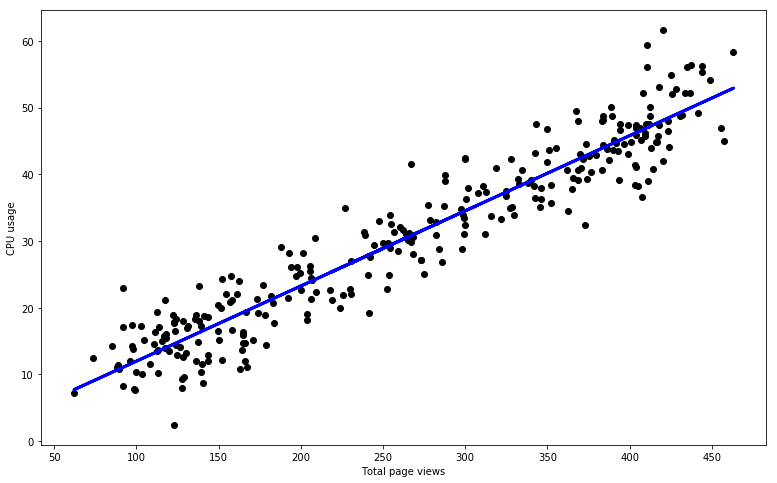

In [15]:
plt.figure(figsize=(13,8))

plt.scatter(total_page_views, cpu_usage,  color='black')
plt.plot(total_page_views, simple_lin_model.predict(total_page_views.reshape((-1, 1))), color='blue', linewidth=3)

plt.xlabel("Total page views")
plt.ylabel("CPU usage")

plt.show()

Our model can calculate the R2 [`score`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) indicating how well the linear model captures the data. A score of 1 means there is perfect linear correlation and the model can fit the data perfectly, a score of 0 (or lower) means that there is no correlation at all (and it does not make sense to try to model it that way). The score method takes the same arguments as the fit method.

In [16]:
simple_lin_model.score(total_page_views.reshape((-1, 1)), cpu_usage)

0.90479192980248935

## 3. Multiple linear regression

A server can host different pages and each of the page views will generate load on the CPU. This load will however not be the same for each page.

Now let us consider the separate page views and build a linear model for that. The model we try to fit takes the form:

$$\text{cpu_usage} = c_0 + c_1 \text{page_views}_1 + c_2 \text{page_views}_2 + \ldots + c_n \text{page_views}_n$$

where the $\text{page_views}_i$'s correspond the our different pages:


In [17]:
import pickle
import sys
if sys.version_info[0] < 3:
    cpu_usage, page_views, page_names, _ = pickle.load(open('data/cpu_page_views.pickle'))
else:
    cpu_usage, page_views, page_names, _ = pickle.load(open('data/cpu_page_views.pickle', 'rb'), encoding='latin1')

We start again by creating a [```LinearRegression```](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) model.

In [18]:
multi_lin_model = sklearn.linear_model.LinearRegression()

Next we fit the model on the data, using `multi_lin_model.fit(X,y)`. In contrast to the case above our `page_views` variable already has the correct shape to pass as the X matrix: it has one column per page.

In [19]:
### BEGIN SOLUTION
multi_lin_model.fit(page_views, cpu_usage)
### END SOLUTION
# multi_lin_model.fit( ? , ? )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now, given the coefficients calculated by the model, which capture the contribution of each page view to the total CPU usage, we can start to answer some interesting questions. For example, 
which page view causes most CPU usage, on a per visit basis? 

For this we can generate a table of page names with their coefficients in descending order:

In [20]:
# Some quick and dirty print code to print the most consuming pages first

print('Index \t CPU (\%) \t\t Page')
print('----------------------------------------------------------')

indices = np.argsort(multi_lin_model.coef_)
for i in indices[::-1]:
    print(i, '\t', multi_lin_model.coef_[i], '\t', page_names[i])

Index 	 CPU (\%) 		 Page
----------------------------------------------------------
5 	 0.303883526981 	 resources/js/basket.js
4 	 0.185425899671 	 api/product/get.php
3 	 0.134709451509 	 api/comment
1 	 0.132923372794 	 products/non-fiction.html
2 	 0.0886649645435 	 products/fiction.html
0 	 0.0408009035885 	 products/science.html


From this table we see that 'resources/js/basket.js' consumes the most per CPU per view. It generates about 0.30% CPU load for each additional page view. 'products/science.html' on the other hand is much leaner and only consumes about 0.04% CPU per view.

Now let us investigate the constant term again.

In [21]:
print('The other processes on the server consume %.2f%%' % multi_lin_model.intercept_)

The other processes on the server consume 0.64%


As you can see this term is very similar to the result achieved in single linear regression, but it is not entirely the same. This means that these models are not perfect. However, the seem to be able to give a reliable estimate.

## 4. Using the sklearn model to explore what-if scenarios

In the previous section we have modeled how much load each individual request generates. But in some cases you might want to transfer one of the request to another server. Now, suppose we want to minimize average CPU usage on this server by deviating traffic of only one webpage to another server, which page should we choose?

For this we simulate diverting the traffic of one page to another server. This means that for the request that is diverted the rate becomes 0, for the other requests we use the average rate.

We implement this by first calculating the `average_request_rates` using [```np.mean```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html). These `average_request_rates` are then fed to the `multi_lin_model.predict()` method but with setting each individual request rate to 0 once.

(For linear models you can also compute the result based on the coefficients, but this approach also works for non-linear models.)

In [22]:
### BEGIN SOLUTION
average_page_views = np.mean(page_views, axis=0)
### END SOLUTION
# average_page_views = 
assert average_page_views.shape == (6,)

predicted_cpus = []

# Loop over all pages
for i in range(len(page_names)):
    # make a copy of the array to avoid overwriting
    tweaked_load = np.copy(average_page_views)
### BEGIN SOLUTION
    tweaked_load[i] = 0
    resulting_cpu = multi_lin_model.predict([tweaked_load])[0]
### END SOLUTION
    # tweaked_load[ ? ] = ?
    # resulting_cpu = ?
    
    predicted_cpus.append(resulting_cpu)

In [23]:
print('CPU\tCoef\tRate\tDiverted page')
print('----------------------------------------------------------')

indices = np.argsort(predicted_cpus)
for i in indices:
    print("%.3f\t%.3f\t%.3f\t%s" % (predicted_cpus[i], multi_lin_model.coef_[i], average_page_views[i], page_names[i]))

CPU	Coef	Rate	Diverted page
----------------------------------------------------------
21.407	0.185	49.898	api/product/get.php
24.441	0.304	20.461	resources/js/basket.js
25.946	0.135	34.986	api/comment
26.168	0.041	110.071	products/science.html
27.963	0.133	20.283	products/non-fiction.html
28.009	0.089	29.888	products/fiction.html


As you can see in the table above, it is best to divert the traffic of 'api/product/get.php' (Why is the result different than the table based on the coefficient)?